## Install STIM Simulator and PyMatching Decoder

STIM is a simulator of circuit noises

Pymatching is a MWPM QEC decoder

In [1]:
# use numpy 1.0 instead of 2.0 for pymatching compatibility later

In [2]:
# !pip install stim~=1.14
# !pip install numpy~=1.0
# !pip install scipy
# !pip install pymatching~=2.0

In [3]:
import stim
print(stim.__version__)
import pymatching
import numpy as np

1.15.0


In [4]:
##########################################################
#################### BEGIN GLUE CODE #####################
##########################################################

# Convert stim detector error model to pymatching decoder.

import stim
import math
import networkx as nx
import pymatching
from typing import Callable, List
import numpy as np

"""Turn detection events into predicted observable errors."""
def predict_observable_errors_using_pymatching(circuit: stim.Circuit,
                                               det_samples: np.ndarray,
                                               ) -> np.ndarray:    
    """ Specifying decompose_errors=True tells Stim it has to output a graph-like error model, where errors are decomposed into pieces with exactly 2 detection events (edges) or exactly 1 detection event (boundary edges). 
    This won't work on all circuits; for example it won't work on a color code circuit. But it does work on repetition codes and surface codes.
    """
    error_model = circuit.detector_error_model(decompose_errors=True, ignore_decomposition_failures=True)
    matching_graph = detector_error_model_to_pymatching_graph(error_model)

    num_shots = det_samples.shape[0]
    num_obs = circuit.num_observables
    num_dets = circuit.num_detectors
    assert det_samples.shape[1] == num_dets

    predictions = np.zeros(shape=(num_shots, num_obs), dtype=bool)
    for k in range(num_shots):
        expanded_det = np.resize(det_samples[k], num_dets + 1)
        expanded_det[-1] = 0
        predictions[k] = matching_graph.decode(expanded_det)
    return predictions

"""Convert a stim error model into a pymatching graph."""
def detector_error_model_to_pymatching_graph(model: stim.DetectorErrorModel) -> pymatching.Matching:
    
    g = detector_error_model_to_nx_graph(model)
    num_detectors = model.num_detectors
    num_observables = model.num_observables

    # Add spandrels to the graph to ensure pymatching will accept it.
    # - Make sure there's only one connected component.
    # - Make sure no detector nodes are skipped.
    # - Make sure no observable nodes are skipped.
    for k in range(num_detectors):
        g.add_node(k)
    g.add_node(num_detectors + 1)
    for k in range(num_detectors + 1):
        g.add_edge(k, num_detectors + 1, weight=100)
    g.add_edge(num_detectors, num_detectors + 1, weight=100, qubit_id=list(range(num_observables)))

    return pymatching.Matching(g)

"""Convert a stim error model into a NetworkX graph."""
def detector_error_model_to_nx_graph(model: stim.DetectorErrorModel) -> nx.Graph:

    g = nx.Graph()
    boundary_node = model.num_detectors
    g.add_node(boundary_node, is_boundary=True, coords=[-1, -1, -1])

    def handle_error(p: float, dets: List[int], frame_changes: List[int]):
        if p == 0:
            return
        if len(dets) == 0:
            # No symptoms for this error.
            # Code probably has distance 1.
            # Accept it and keep going, though of course decoding will probably perform terribly.
            return
        if len(dets) == 1:
            dets = [dets[0], boundary_node]
        if len(dets) > 2:
            raise NotImplementedError(
                f"Error with more than 2 symptoms can't become an edge or boundary edge: {dets!r}.")
        if g.has_edge(*dets):
            edge_data = g.get_edge_data(*dets)
            old_p = edge_data["error_probability"]
            old_frame_changes = edge_data["qubit_id"]
            # If frame changes differ, the code has distance 2; just keep whichever was first.
            if set(old_frame_changes) == set(frame_changes):
                p = p * (1 - old_p) + old_p * (1 - p)
                g.remove_edge(*dets)
        g.add_edge(*dets, weight=math.log((1 - p) / p), qubit_id=frame_changes, error_probability=p)

    def handle_detector_coords(detector: int, coords: np.ndarray):
        g.add_node(detector, coords=coords)

    eval_model(model, handle_error, handle_detector_coords)

    return g

"""Interprets the error model instructions, taking care of loops and shifts.
    Makes callbacks as error mechanisms are declared, and also when detector
    coordinate data is declared.
    """
def eval_model(
        model: stim.DetectorErrorModel,
        handle_error: Callable[[float, List[int], List[int]], None],
        handle_detector_coords: Callable[[int, np.ndarray], None]):
    
    det_offset = 0
    coords_offset = np.zeros(100, dtype=np.float64)

    def _helper(m: stim.DetectorErrorModel, reps: int):
        nonlocal det_offset
        nonlocal coords_offset
        for _ in range(reps):
            for instruction in m:
                if isinstance(instruction, stim.DemRepeatBlock):
                    _helper(instruction.body_copy(), instruction.repeat_count)
                elif isinstance(instruction, stim.DemInstruction):
                    if instruction.type == "error":
                        dets: List[int] = []
                        frames: List[int] = []
                        t: stim.DemTarget
                        p = instruction.args_copy()[0]
                        for t in instruction.targets_copy():
                            if t.is_relative_detector_id():
                                dets.append(t.val + det_offset)
                            elif t.is_logical_observable_id():
                                frames.append(t.val)
                            elif t.is_separator():
                                # Treat each component of a decomposed error as an independent error.
                                # (Ideally we could configure some sort of correlated analysis; oh well.)
                                handle_error(p, dets, frames)
                                frames = []
                                dets = []
                        # Handle last component.
                        handle_error(p, dets, frames)
                    elif instruction.type == "shift_detectors":
                        det_offset += instruction.targets_copy()[0]
                        a = np.array(instruction.args_copy())
                        coords_offset[:len(a)] += a
                    elif instruction.type == "detector":
                        a = np.array(instruction.args_copy())
                        for t in instruction.targets_copy():
                            handle_detector_coords(t.val + det_offset, a + coords_offset[:len(a)])
                    elif instruction.type == "logical_observable":
                        pass
                    else:
                        raise NotImplementedError()
                else:
                    raise NotImplementedError()
    _helper(model, 1)

##########################################################
##################### END GLUE CODE ######################
##########################################################

# function to calculate logical errors by comparing each observables
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    shots = circuit.compile_detector_sampler().sample(num_shots, append_observables=True) # append observables to sampling result

    detector_parts = shots[:, :circuit.num_detectors] # ':' means all shots, num_detectors all detectors
    actual_observable_parts = shots[:, circuit.num_detectors:] # means all observables
    predicted_observable_parts = predict_observable_errors_using_pymatching(circuit, detector_parts)

    num_errors = 0
    for actual, predicted in zip(actual_observable_parts, predicted_observable_parts):
        if not np.array_equal(actual, predicted):
            num_errors += 1
    return num_errors # compare each observable and get result.

## Surface Code Example

In [5]:
'''
Rotated Surface code array for Z error
'''

import os

def square_4_circ(error_rate: float, rounds: int, distance : int = 3) -> str:
    
    w = distance
    h = distance

    # init all qubits
    dqbits = []
    for i in range(0, w):
        for j in range(0, h):
            dqbits.append((j, i))
    
    cnt = len(dqbits)
    mz4q_dict = {}
    for i in range(0, w-1, 2):
        for j in range(0, h-1, 2):
            mz4q_dict[(0, cnt)] = (j, i)
            cnt += 1
    for i in range(1, w-1, 2):
        for j in range(1, h-1, 2):
            mz4q_dict[(0, cnt)] = (j, i)
            cnt += 1
    mz2q_dict = {}
    for j in range(1, h-1, 2):
        mz2q_dict[(0, cnt)] = (j, 0)
        cnt += 1
    for j in range(0, h-1, 2):
        mz2q_dict[(0, cnt)] = (j, w-1)
        cnt += 1
    mx4q_dict = {}
    for i in range(1, w-1, 2):
        for j in range(0, h-1, 2):
            mx4q_dict[(0, cnt)] = (j, i)
            cnt += 1
    for i in range(0, w-1, 2):
        for j in range(1, h-1, 2):
            mx4q_dict[(0, cnt)] = (j, i)
            cnt += 1
    mx2q_dict = {}
    for i in range(0, w-1, 2):
        mx2q_dict[(0, cnt)] = (0, i)
        cnt += 1
    for i in range(1, w-1, 2):
        mx2q_dict[(0, cnt)] = (h-1, i)
        cnt += 1

    mxqbits_four = list(mx4q_dict.keys())
    mxqbits_two = list(mx2q_dict.keys())
    mzqbits_four = list(mz4q_dict.keys())
    mzqbits_two = list(mz2q_dict.keys())
    
    allqbits = dqbits + mzqbits_four + mzqbits_two + mxqbits_four + mxqbits_two
    mqbits = mxqbits_four + mxqbits_two + mzqbits_four + mzqbits_two

    all_qubit_numbering = {qb: i for i, qb in enumerate(allqbits)}
    
    '''Convert 2D coordinate into 1D qubit order'''
    T : Callable[[tuple], int] = lambda qb: all_qubit_numbering[qb]
    TARGET : Callable[[list], str] = lambda qlist: "".join([' %d' % T(qb) for qb in qlist])
    X_ERROR : Callable[[float, list], str] = lambda error_rate, qlist: 'X_ERROR(%lf)' % (error_rate) + TARGET(qlist) # X errors
    R : Callable[[list], str]  = lambda qlist: 'R' + TARGET(qlist) # reset to |0>.
    TICK = 'TICK' # used as a barrier for different layer of circuit
    DEPOLARIZE1 : Callable[[float, list], str] = lambda error_rate, qlist: 'DEPOLARIZE1(%lf)' % (error_rate) + TARGET(qlist) # single-qubit Depolarization errors
    DEPOLARIZE2 : Callable[[float, list], str] = lambda error_rate, qlist: 'DEPOLARIZE2(%lf)' % (error_rate) + TARGET(qlist) # two-qubit Depolarization errors
    H : Callable[[list], str]  = lambda qlist: 'H' + TARGET(qlist) # H gate
    CX : Callable[[list], str]  = lambda qlist: 'CX' + TARGET(qlist) # CX gate
    # MR : Callable[[list], str]  = lambda qlist: 'MR' + TARGET(qlist) # MR gate, measure and reset
    # M : Callable[[list], str]  = lambda qlist: 'M' + TARGET(qlist) # M gate, measure and reset
    LF : Callable[[tuple], tuple] = lambda qbit: (qbit[0], qbit[1]-1)
    RF : Callable[[tuple], tuple] = lambda qbit: (qbit[0], qbit[1]+1)
    UP : Callable[[tuple], tuple] = lambda qbit: (qbit[0]-1, qbit[1])
    DW : Callable[[tuple], tuple] = lambda qbit: (qbit[0]+1, qbit[1])
    def generate_dot(allqbits) -> str:
        s = ""
        for pos in allqbits:
            s += "QUBIT_COORDS(%d, %d) %d\n" % (*pos, T(pos))
        return s
    
    meas_list = [] # measure list
    def MR(qlist: list, flag: int) -> str:
        '''flag: 
        X stabilizer: 1, 
        Z stabilizer: 2, 
        logical qubit: 3.'''
        _ = [ meas_list.append(qbit+(flag,)) for qbit in qlist ]
        return 'MR' + TARGET(qlist)

    def M(qlist: list, flag: int) -> str:
        '''flag: 
        X stabilizer: 1, 
        Z stabilizer: 2, 
        logical qubit: 3.'''
        _ = [ meas_list.append(qbit+(flag,)) for qbit in qlist ]
        return 'M' + TARGET(qlist)
    
    M1 = lambda qbit, flag: max(loc for loc, val in enumerate(meas_list) if val == (qbit+(flag,))) - len(meas_list) # last measured time
    M2 = lambda qbit, flag: max([loc for loc, val in enumerate(meas_list) if val == (qbit+(flag,))][:-1]) - len(meas_list) # 2nd last measured time

    newline = os.linesep
    
    after_reset_flip_error = error_rate # this may incur error decomposition failing.
    before_measure_flip_error = error_rate
    before_round_data_depolarization = error_rate
    after_clifford_depolarization = error_rate

    circ = generate_dot(allqbits)
    circ += R(dqbits) + newline  # reset data qubits
    # circ += X_ERROR(after_reset_flip_error, dqbits) + newline #  after reset flip error on data qubits
    circ += R(mqbits) + newline # reset measurement/parity qubits
    # circ += X_ERROR(after_reset_flip_error, mzqbits_four) + newline #  after reset flip error on parity qubits
    circ += TICK + newline
    circ += DEPOLARIZE1(before_round_data_depolarization, dqbits) + newline
    
    # first start X measurements
    qlist = [qb for qb in mxqbits_four + mxqbits_two]
    circ += H(qlist) + newline + DEPOLARIZE1(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, RF(pos_dq)])
    for i in mxqbits_two:
        pos_dq = mx2q_dict[i]
        qlist.extend([i, RF(pos_dq)])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, RF(DW(pos_dq))])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, pos_dq])
    for i in mxqbits_two:
        pos_dq = mx2q_dict[i]
        qlist.extend([i, pos_dq])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, DW(pos_dq)])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = [qb for qb in mxqbits_four + mxqbits_two]
    circ += H(qlist) + newline + DEPOLARIZE1(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = [qb for qb in mxqbits_four + mxqbits_two]
    circ += X_ERROR(before_measure_flip_error, qlist) + newline + MR(qlist, 1) + newline # + X_ERROR(after_reset_flip_error, qlist) + newline
    
    # second, start Z measurements
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([RF(pos_dq), i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([RF(DW(pos_dq)), i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([pos_dq, i])
    for i in mzqbits_two:
        pos_dq = mz2q_dict[i]
        qlist.extend([pos_dq, i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([DW(pos_dq), i])
    for i in mzqbits_two:
        pos_dq = mz2q_dict[i]
        qlist.extend([DW(pos_dq), i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = [qb for qb in mzqbits_four + mzqbits_two]
    circ += X_ERROR(before_measure_flip_error, qlist) + newline + MR(qlist, 2) + newline # + X_ERROR(after_reset_flip_error, qlist) + newline

    # first X measurement, second Z measurement
    # qlist = [qb for qb in mxqbits_four + mxqbits_two]
    circ += "SHIFT_COORDS(%d, %d, %d)" % (0,0,1) + newline
    qlist = [qb for qb in mzqbits_four + mzqbits_two]
    for qb in qlist:
        circ += "DETECTOR(%d,%d,0) rec[%d]" % (qb[0],qb[1],M1(qb, 2)) + newline
        
    circ += "REPEAT %d {" % rounds + newline
    circ += TICK + newline + DEPOLARIZE1(before_round_data_depolarization, dqbits) + newline

    # first start X measurements
    qlist = [qb for qb in mxqbits_four + mxqbits_two]
    circ += H(qlist) + newline + DEPOLARIZE1(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, RF(pos_dq)])
    for i in mxqbits_two:
        pos_dq = mx2q_dict[i]
        qlist.extend([i, RF(pos_dq)])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, RF(DW(pos_dq))])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, pos_dq])
    for i in mxqbits_two:
        pos_dq = mx2q_dict[i]
        qlist.extend([i, pos_dq])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mxqbits_four:
        pos_dq = mx4q_dict[i]
        qlist.extend([i, DW(pos_dq)])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = [qb for qb in mxqbits_four + mxqbits_two]
    circ += H(qlist) + newline + DEPOLARIZE1(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = [qb for qb in mxqbits_four + mxqbits_two]
    circ += X_ERROR(before_measure_flip_error, qlist) + newline + MR(qlist, 1) + newline # + X_ERROR(after_reset_flip_error, qlist) + newline
    
    # second, start Z measurements
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([RF(pos_dq), i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([RF(DW(pos_dq)), i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([pos_dq, i])
    for i in mzqbits_two:
        pos_dq = mz2q_dict[i]
        qlist.extend([pos_dq, i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = []
    for i in mzqbits_four:
        pos_dq = mz4q_dict[i]
        qlist.extend([DW(pos_dq), i])
    for i in mzqbits_two:
        pos_dq = mz2q_dict[i]
        qlist.extend([DW(pos_dq), i])
    circ += CX(qlist) + newline + DEPOLARIZE2(after_clifford_depolarization, qlist) + newline + TICK + newline
    qlist = [qb for qb in mzqbits_four + mzqbits_two]
    circ += X_ERROR(before_measure_flip_error, qlist) + newline + MR(qlist, 2) + newline # + X_ERROR(after_reset_flip_error, qlist) + newline
    
    # first assert X measurements preserves
    circ += "SHIFT_COORDS(%d, %d, %d)" % (0,0,1) + newline
    qlist = [qb for qb in mxqbits_four + mxqbits_two]
    for qb in qlist:
        circ += "DETECTOR(%d,%d,0) rec[%d] rec[%d]" % (qb[0],qb[1],M1(qb, 1), M2(qb, 1)) + newline

    # second assert Z measurements preserves
    circ += "SHIFT_COORDS(%d, %d, %d)" % (0,0,1) + newline
    qlist = [qb for qb in mzqbits_four + mzqbits_two]
    for qb in qlist:
        circ += "DETECTOR(%d,%d,0) rec[%d] rec[%d]" % (qb[0],qb[1],M1(qb, 2), M2(qb, 2)) + newline # assert continuous measurement holds
    circ += "}" + newline

    # enter into final error assertion events, measure all data qubits
    circ += X_ERROR(before_measure_flip_error, dqbits) + newline + M(dqbits, 3) + newline

    # let us assert more stabilizers
    for qb in mzqbits_four:
        pos_dq = mz4q_dict[qb]
        dqa, dqb, dqc, dqd = pos_dq, RF(pos_dq), DW(pos_dq), DW(RF(pos_dq))
        circ += "DETECTOR(%d,%d,0) rec[%d] rec[%d] rec[%d] rec[%d] rec[%d]" % (qb[0],qb[1],M1(dqa, 3), M1(dqb, 3), M1(dqc, 3), \
                                                                               M1(dqd, 3), M1(qb, 2)) + newline
    for qb in mzqbits_two:
        pos_dq = mz2q_dict[qb]
        circ += "DETECTOR(%d,%d,0) rec[%d] rec[%d] rec[%d]" % (qb[0],qb[1],M1(pos_dq, 3), M1(DW(pos_dq), 3), M1(qb, 2)) + newline

    # assert the Z logical operation
    qlist = []
    for i in range(0, w):
        qlist.append((w-1-i, i)) # anti-diagonal as logical Z
    circ += "OBSERVABLE_INCLUDE(0)"
    for qb in qlist:
        circ += " rec[%d]" % M1(qb, 3)
    circ += newline

    return circ

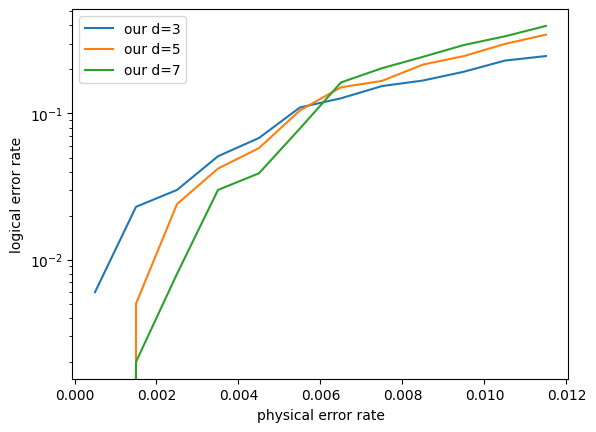

In [6]:
import matplotlib.pylab as plt

num_shots = 1000
noise_range = [0.0005, 0.0015, 0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075, 0.0085, 0.0095, 0.0105, 0.0115]
noise_range = [noise for noise in noise_range]
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in noise_range:
        circstr = square_4_circ(noise, d*3, d)
        circuit = stim.Circuit(circstr)
        xs.append(noise)
        ys.append(count_logical_errors(circuit, num_shots) / num_shots)
    plt.plot(xs, ys, label="our d=" + str(d))

plt.semilogy()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.legend()
plt.show()

In [ ]:
for d in [3,5,7]:
    xs = []
    ys = []
    for noise in noise_range:
        orig_circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise)
        xs.append(noise)
        ys.append(count_logical_errors(orig_circuit, num_shots) / num_shots)
    plt.plot(xs, ys, label="orig d=" + str(d))
plt.semilogy()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.legend()
plt.show()

## GKP Error Model

In [ ]:
import scipy as sp

def compute_gkp_white_noise(sigma, n=10, _cdf=sp.special.ndtr):
    s = 0
    for i in range(0, n+1):
        s += _cdf((2*i+1.5)*np.sqrt(np.pi)/sigma) - _cdf((2*i+0.5)*np.sqrt(np.pi)/sigma)

    s = 0
    for i in range(0, n+1):
        s += (_cdf((2*i+1.5)*np.sqrt(np.pi)/sigma) - _cdf((2*i+0.5)*np.sqrt(np.pi)/sigma))
    
    return s

In [ ]:
compute_gkp_white_noise(0.01)